# 导入模块

In [1]:
import os
import sys

syspath = os.path.split(os.path.abspath("."))[0]
sys.path.append(syspath)

In [2]:
import univ3api.simulation as sim
import univ3api.utils as utils
import importlib
import pandas as pd

In [3]:
# run if simulation file is updated
importlib.reload(sim)

<module 'univ3api.simulation' from 'D:\\2020Tool\\univ3apiChannel\\univ3api\\simulation.py'>

## 链上数据

### SwapEvent

记录了该流动性池的每一笔swap

### Block

区块信息，用于提供时间戳

In [4]:
HOST = "mongodb://172.16.11.81:27017/ETHDATA"
source = sim.DataUtilMongoDB(HOST)

# 转时间成Timestamp

In [5]:
from datetime import datetime
import time
d1 = datetime(2021,5, 10, 9)
d2 = datetime(2021,9, 1,9)
t1 = int(time.mktime(d1.timetuple()))
t2 = int(time.mktime(d2.timetuple()))

In [6]:
swapdata = source.swap_by_time("SWAP_WETH_USDT_3000", t1, t2)

### 先生成带时间戳的价格数据

In [7]:
swapdata.tail()

,transactionHash,logIndex,transactionIndex,blockNumber,recipient,amount0,amount1,sqrtPriceX96,liquidity,tick,timestamp
89854,0x6b236a1c63e56cf0fa11140df8e0066544a507ad64c3...,79,15,13136619,0x56178a0d5F301bAf6CF3e1Cd53d9863437345Bf9,145814684683602982470,-497167401705,4631662768854013417290124,12664890714804986397,-194954,1630457126
89855,0x0cd53e138d82fc204f6fd482d9fa8529b97d1d2e6527...,14,3,13136627,0x56178a0d5F301bAf6CF3e1Cd53d9863437345Bf9,138778256571029358535,-472556781740,4628706580257992200781605,12664890714804986397,-194966,1630457282
89856,0x1f40d32e3d8b481195f4f54f46e3ff9a6dc546c2cf77...,62,8,13136628,0x30c5312d9CF0d873994f000e72F1cbf561D0209C,5905315769464742801,-20094935817,4628580871724334153468064,12664890714804986397,-194967,1630457308
89857,0x6a6fe9781450b9e13bb2b9ab76d169e5a3ef1e0d92cb...,11,2,13136630,0x56178a0d5F301bAf6CF3e1Cd53d9863437345Bf9,120371991767956761948,-409370738059,4626019958085682040554705,12664890714804986397,-194978,1630457355
89858,0x15f56ed54c6e396a1898ce49008bb762a6aa5829afdb...,3,0,13136650,0x56178a0d5F301bAf6CF3e1Cd53d9863437345Bf9,72937003999237118414,-247829694775,4624469601925831472801006,12664890714804986397,-194985,1630457561


In [8]:
pricedata = swapdata[["timestamp", "sqrtPriceX96"]]
pricedata["price"] = pricedata["sqrtPriceX96"].apply(utils.PriceConverter(18, 6).x96_to_price)

C:\Users\channelchan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
pricedata.tail()

,timestamp,sqrtPriceX96,price
89854,1630457126,4631662768854013417290124,3417.548561
89855,1630457282,4628706580257992200781605,3413.187409
89856,1630457308,4628580871724334153468064,3413.002017
89857,1630457355,4626019958085682040554705,3409.226352
89858,1630457561,4624469601925831472801006,3406.941611


## 生成日价格大于50均线的DataFrame

In [10]:
priceDf = pricedata

In [11]:
priceDf['datetime'] = list(map(lambda d: datetime.fromtimestamp(d), priceDf['timestamp'] ))

C:\Users\channelchan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
priceDt = priceDf.set_index('datetime')

In [13]:
priceDay = priceDt.resample('D').last()

In [14]:
priceDay['MA50'] = priceDay['price'].rolling(50).mean()

In [15]:
priceDay['Trend'] = priceDay['price']>=priceDay['MA50']

In [16]:
priceDay.index = list(map(lambda d: d.date(), priceDay.index))

In [17]:
trendDict = dict(priceDay['Trend'])

In [18]:
priceDt['date'] = list(map(lambda d: d.date(), priceDt.index))

In [19]:
priceDt

,timestamp,sqrtPriceX96,price,date
datetime,,,,
2021-05-10 09:00:15,1620608415,4950372593694415524150419,3904.061118,2021-05-10
2021-05-10 09:03:40,1620608620,4950714025650391927763989,3904.599670,2021-05-10
2021-05-10 09:05:17,1620608717,4950722657183851518816584,3904.613285,2021-05-10
2021-05-10 09:19:10,1620609550,4949701065479238300877944,3903.002002,2021-05-10
2021-05-10 09:21:38,1620609698,4949886229297224528026940,3903.294023,2021-05-10
...,...,...,...,...
2021-09-01 08:45:26,1630457126,4631662768854013417290124,3417.548561,2021-09-01
2021-09-01 08:48:02,1630457282,4628706580257992200781605,3413.187409,2021-09-01
2021-09-01 08:48:28,1630457308,4628580871724334153468064,3413.002017,2021-09-01


In [20]:
trendList = []
for i, v in priceDt.iterrows():
    trendList.append(trendDict[v['date']])

In [21]:
priceDt['trend'] = trendList

In [22]:
priceDt.tail()

,timestamp,sqrtPriceX96,price,date,trend
datetime,,,,,
2021-09-01 08:45:26,1630457126,4631662768854013417290124,3417.548561,2021-09-01,True
2021-09-01 08:48:02,1630457282,4628706580257992200781605,3413.187409,2021-09-01,True
2021-09-01 08:48:28,1630457308,4628580871724334153468064,3413.002017,2021-09-01,True
2021-09-01 08:49:15,1630457355,4626019958085682040554705,3409.226352,2021-09-01,True
2021-09-01 08:52:41,1630457561,4624469601925831472801006,3406.941611,2021-09-01,True


### 初始化参数

In [23]:
init_price = priceDt["price"][0]

decimal0 = 18
decimal1 = 6

init_amount0 = 0
init_amount1 = 1000000*1e6

### 运行策略

In [25]:
import ethusdt_strategy
importlib.reload(utils)
importlib.reload(sim)
importlib.reload(ethusdt_strategy)

strategy = ethusdt_strategy.HoldStrategy(init_amount0, init_amount1, decimal0, decimal1, sim.PoolFee.low, False)
strategy.init(swapdata.iloc[0].to_dict())
strategy.run(swapdata, priceDt)
report = strategy.report()

C:\Users\channelchan\Anaconda3\lib\site-packages\pandas\core\frame.py:1554: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


$$$$$$$: 2670.057793611629
$$$$$$$: 1708.8369879114427
######: 101756322027883072 228638780244870037504 499750000000
t0: 228638780244870266880 t1: 499750000000
1627228257, 12896322
Mint position： Position(L=101370775942769696, tick=[-201900, -197460], range=[1706.2113, 2659.8057])
Mint amount: token0=226.8863962841141, token1=499750.0
Wallet amount: token0=6.977599094808281, token1=0.0
Price(2672.479561316052) out of range(1708.8369879114427, 2670.057793611629)
1627848347, 12941671
Decreased position： Position(L=0, tick=[-201900, -197460], range=[1706.2113, 2659.8057])
Decreased amount: token0=0.0, token1=1040773.146157
Wallet amount: token0=6.977599094808281, token1=1040773.146157
$$$$$$$: 3345.2186488996817
$$$$$$$: 2140.9399352957967
######: 93364043660190848 189435063876001431552 520804894709
t0: 189435063876001431552 t1: 520804894709
1627848487, 12941682
Mint position： Position(L=92725112177527712, tick=[-199680, -195180], range=[2130.3029, 3340.9048])
Mint amount: token0=189.4350

### 池子在回测时间内发生了3次撤池与重建

### 画图 查看每次建池的资产状况

In [27]:
# report.positions[1].plot_balance()

In [28]:
report.positions[1].get_balance(plain=True, draw_plot=True)

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-07-25 23:50:57,226.886396,0.000000,0.000000,0.000000,4.997500e+05,0.000000,0.000000,0.000000
1,2021-07-26 00:13:45,227.780678,0.000447,0.000447,0.000447,4.978390e+05,0.000000,0.000000,0.000000
2,2021-07-26 00:42:50,228.18275,0.000201,0.000648,0.000648,4.969803e+05,0.000000,0.000000,0.000000
3,2021-07-26 00:43:04,228.566847,0.000192,0.000840,0.000840,4.961603e+05,0.000000,0.000000,0.000000
4,2021-07-26 00:44:59,228.931064,0.000182,0.001022,0.001022,4.953830e+05,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
3443,2021-08-02 03:53:44,2.462183,0.000000,0.464564,0.464564,1.034232e+06,1.756217,1354.438320,1354.438320
3444,2021-08-02 04:04:19,1.233724,0.000000,0.464564,0.464564,1.037494e+06,1.630663,1356.068983,1356.068983
3445,2021-08-02 04:04:44,0.0,0.000000,0.464564,0.464564,1.040773e+06,1.639703,1357.708686,1357.708686
3446,2021-08-02 04:05:47,0.0,0.000000,0.464564,0.464564,1.040773e+06,0.000000,1357.708686,1357.708686


,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-08-02 04:08:07,189.435064,0.000000,0.000000,0.000000,5.137737e+05,0.000000,0.000000,0.000000
1,2021-08-02 04:08:31,188.196261,0.000000,0.000000,0.000000,5.170867e+05,1.656481,1.656481,1.656481
2,2021-08-02 04:13:09,186.26435,0.000000,0.000000,0.000000,5.222624e+05,2.587855,4.244336,4.244336
3,2021-08-02 04:15:47,184.475649,0.000000,0.000000,0.000000,5.270644e+05,2.401004,6.645340,6.645340
4,2021-08-02 04:20:43,184.322884,0.000000,0.000000,0.000000,5.274750e+05,0.205281,6.850621,6.850621
...,...,...,...,...,...,...,...,...,...
9342,2021-08-23 18:00:56,0.016694,0.000000,1.142309,1.142309,1.079761e+06,0.629316,3683.591682,3683.591682
9343,2021-08-23 18:01:39,0.0,0.000000,1.142309,1.142309,1.079817e+06,0.027886,3683.619568,3683.619568
9344,2021-08-23 18:02:53,0.0,0.000000,1.142309,1.142309,1.079817e+06,0.000000,3683.619568,3683.619568
9345,2021-08-23 18:03:39,0.0,0.000000,1.142309,1.142309,1.079817e+06,0.000000,3683.619568,3683.619568


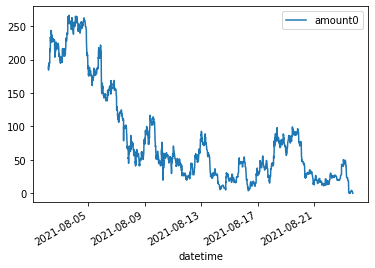

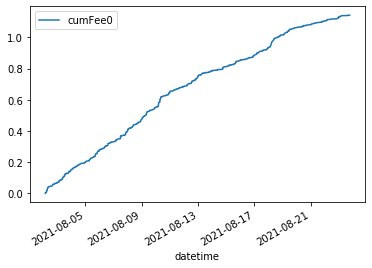

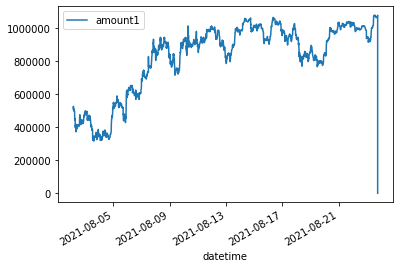

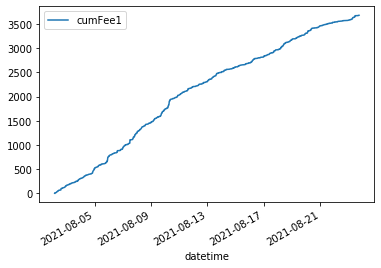

In [29]:
report.positions[2].get_balance(plain=True, draw_plot=True)

,datetime,amount0,fee0,cumFee0,collectedFee0,amount1,fee1,cumFee1,collectedFee1
0,2021-08-23 18:03:42,160.356356,0.000000,0.000000,0.000000,544485.060821,0.000000,0.000000,0.000000
1,2021-08-23 18:03:54,160.335886,0.000000,0.000000,0.000000,544553.568340,0.034253,0.034253,0.034253
2,2021-08-23 18:05:07,160.012661,0.000000,0.000000,0.000000,545635.525052,0.540978,0.575231,0.575231
3,2021-08-23 18:05:27,159.561291,0.000000,0.000000,0.000000,547147.198077,0.755836,1.331067,1.331067
4,2021-08-23 18:06:09,159.556514,0.000000,0.000000,0.000000,547163.202069,0.008001,1.339068,1.339068
...,...,...,...,...,...,...,...,...,...
2670,2021-09-01 08:42:54,143.290989,0.000415,0.263985,0.263985,602236.940020,0.000000,882.000803,882.000803
2671,2021-09-01 08:45:26,144.31197,0.000510,0.264496,0.264496,598745.345097,0.000000,882.000803,882.000803
2672,2021-09-01 08:48:02,145.283692,0.000486,0.264982,0.264982,595426.558399,0.000000,882.000803,882.000803
2673,2021-09-01 08:48:28,145.325041,0.000021,0.265002,0.265002,595285.430796,0.000000,882.000803,882.000803


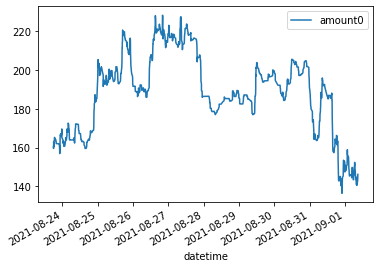

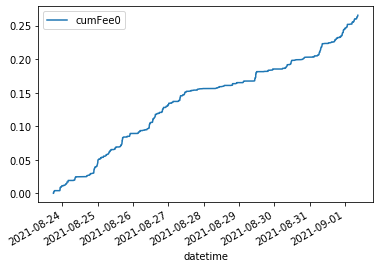

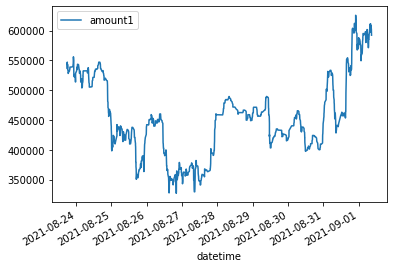

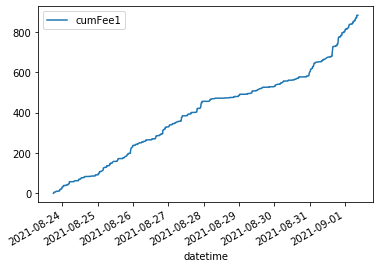

In [30]:
report.positions[3].get_balance(plain=True, draw_plot=True)

### 展示总体资产状况

```
TotalAmount = WalletAmount + AmountInPositions + CummulativeFee
```

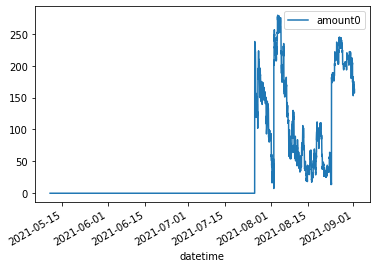

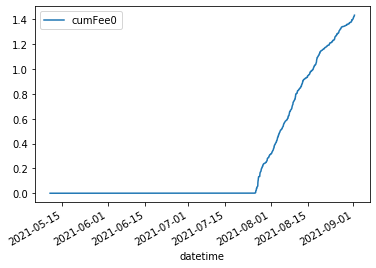

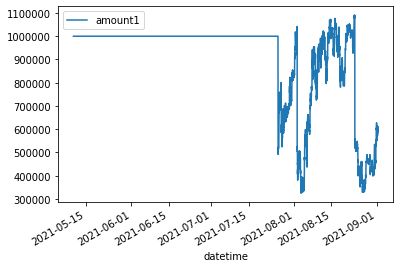

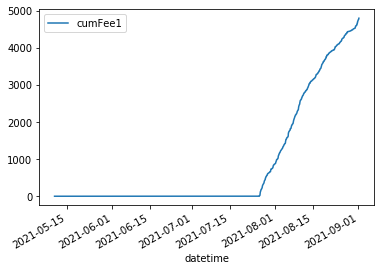

In [31]:
total_balance = report.total_balance(draw_plot=True, plain=True)

In [32]:
price = pricedata.drop_duplicates("timestamp").set_index("timestamp")["price"]
price

timestamp
1620608415    3904.061118
1620608620    3904.599670
1620608717    3904.613285
1620609550    3903.002002
1620609698    3903.294023
                 ...     
1630457126    3417.548561
1630457282    3413.187409
1630457308    3413.002017
1630457355    3409.226352
1630457561    3406.941611
Name: price, Length: 72807, dtype: float64

In [33]:
eth_balance = total_balance.set_index("timestamp")[["amount0", "cumFee0"]].sum(axis=1) * price

In [36]:
usdt_balance = total_balance.set_index("timestamp")[["amount1", "cumFee1"]].sum(axis=1)

In [37]:
usdt_balance+eth_balance

timestamp
1620608415    1.000000e+06
1620608620    1.000000e+06
1620608717    1.000000e+06
1620609550    1.000000e+06
1620609698    1.000000e+06
                  ...     
1630457126    1.159184e+06
1630457282    1.158478e+06
1630457308    1.158448e+06
1630457355    1.157833e+06
1630457561             NaN
Length: 72807, dtype: float64

In [38]:
# eth_balance.plot()
# usdt_balance.plot()
tb_Timing = (usdt_balance+eth_balance)

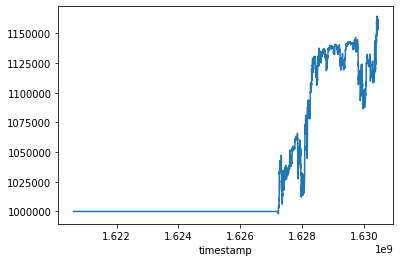

In [39]:
tb_Timing.plot()

### 账户总体市值和价格变动


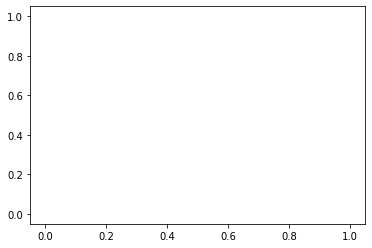

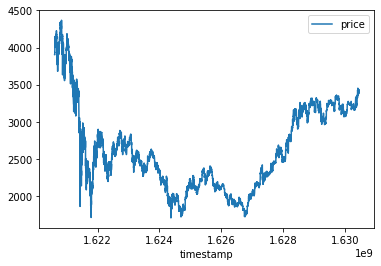

In [40]:
assets_value = pricedata.set_index("timestamp")["price"] * (total_balance["amount1"] / 10**decimal1) + total_balance["amount0"] / 10**decimal0
assets_value.plot()
pricedata.set_index("timestamp")[["price"]].plot()